In [33]:
import sys
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

project_root = os.path.abspath(os.path.join('..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.patch_utils import extract_patches
from src.feature_extractor import FeatureExtractor
from src.search_engine import FaissSearch

print("Imports successful!")

Imports successful!


In [94]:
# Configuration

IMAGE_PATH = '../data/raw_maps/sample_venice_map_3.jpg'

PATCH_SIZE = (224, 224)
STRIDE = (112, 112) # 50% overlap
PATCH_SIZE = (112, 112)
STRIDE = (56, 56) # 50% overlap
K_NEIGHBORS = 6     # Number of search results
CLIP_MODEL = 'openai/clip-vit-base-patch32' # CLIP model
FEATURE_DIM = 512   # Feature dimension for CLIP-base model

In [95]:
# Tile Extraction
patches_data = extract_patches(IMAGE_PATH, patch_size=PATCH_SIZE, stride=STRIDE)
patch_images = [item['patch'] for item in patches_data]

Extracting patches from ../data/raw_maps/sample_venice_map_3.jpg...


Patching Image: 100%|██████████| 4171/4171 [00:00<00:00, 17829.04it/s]

Successfully extracted 4171 patches.


In [ ]:
# Feature Extraction
extractor = FeatureExtractor(model_name=CLIP_MODEL)
image_features = extractor.extract_image_features(patch_images)

print(f"\nFeature extraction complete. Feature matrix shape: {image_features.shape}")

FeatureExtractor using device: cpu
Extracting image features using CLIP...


Extracting Features:  15%|█▌        | 10/66 [00:32<03:08,  3.37s/it]

In [71]:
# Build FAISS Index
search_engine = FaissSearch(feature_dim=FEATURE_DIM)
search_engine.build_index(image_features)

FAISS: GPU support detected. Moving index to GPU.
Index is already trained.
Building index with 1008 vectors...
Index built. Total vectors in index: 1008


--- Demo 1: Image-to-Image Search ---


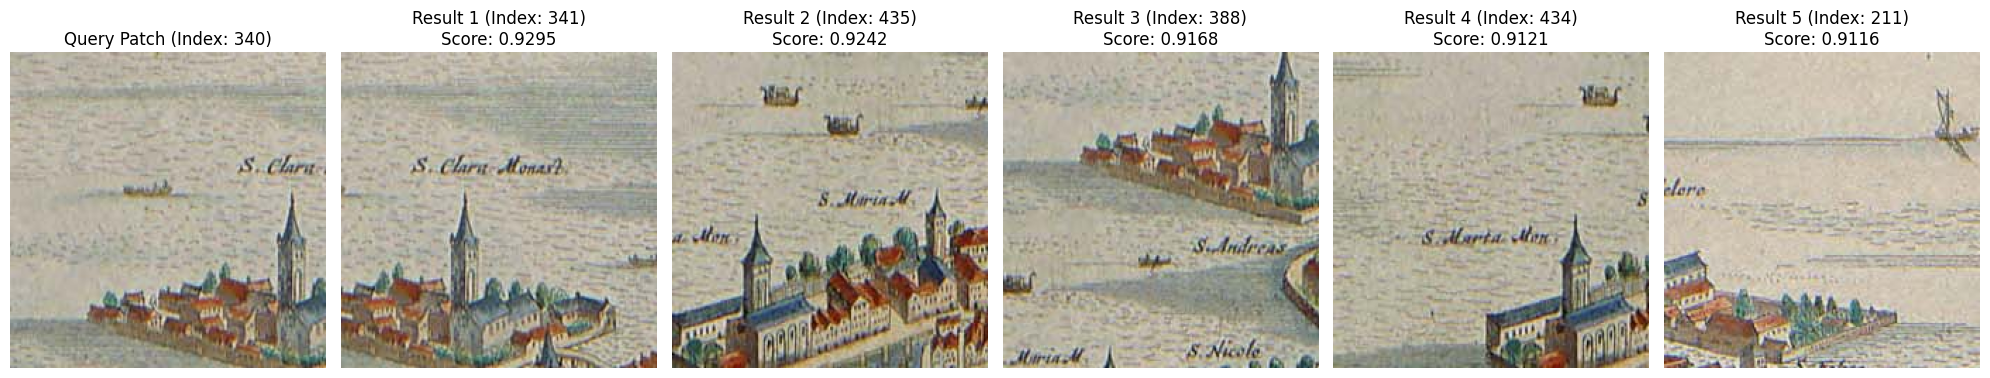

In [92]:
## Search Demo 1 - Image-to-Image
print("--- Demo 1: Image-to-Image Search ---")

# Randomly select a tile as the query
query_index = random.randint(0, len(patches_data) - 1)
query_patch = patches_data[query_index]['patch']
query_vector = np.expand_dims(image_features[query_index], axis=0) # Keep 2D shape

# Execute the search
distances, indices = search_engine.search(query_vector, k=K_NEIGHBORS)

# Visualize the results
fig, axes = plt.subplots(1, K_NEIGHBORS, figsize=(20, 4))
axes[0].imshow(query_patch)
axes[0].set_title(f"Query Patch (Index: {query_index})")
axes[0].axis('off')

for i, (idx, dist) in enumerate(zip(indices[0][1:], distances[0][1:])):
    result_patch = patches_data[idx]['patch']
    axes[i+1].imshow(result_patch)
    axes[i+1].set_title(f"Result {i+1} (Index: {idx})\nScore: {dist:.4f}")
    axes[i+1].axis('off')

plt.tight_layout()
plt.show()


--- Demo 2: Text-to-Image Search ---
Extracting text features for: 'a large building with many windows'


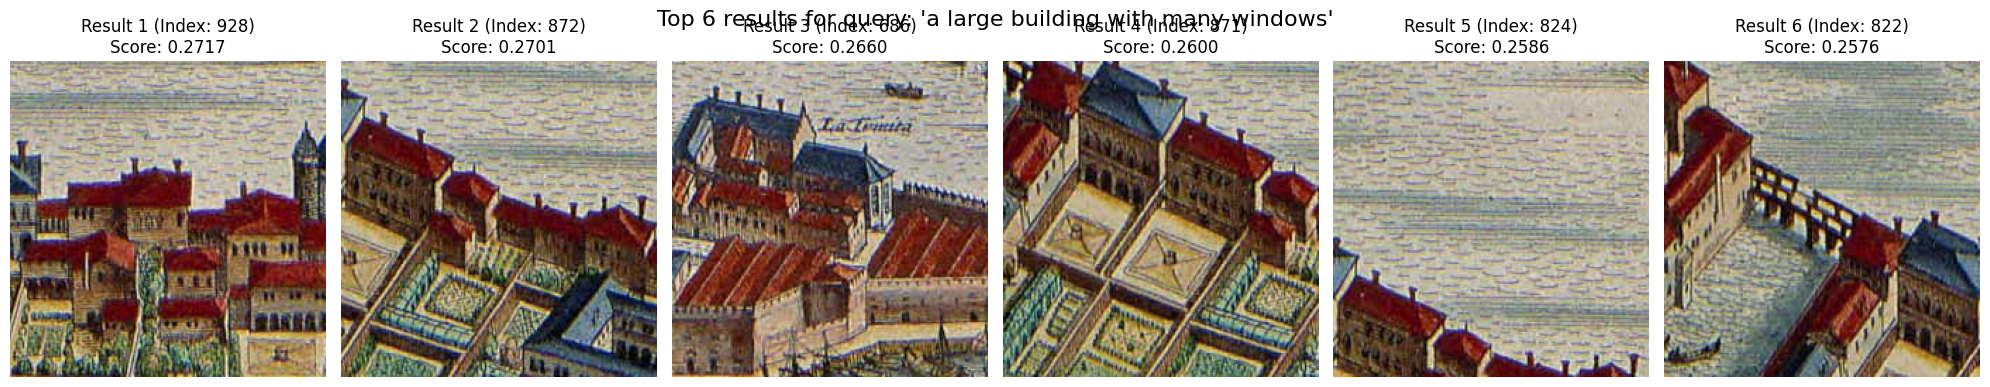

In [93]:
## Search Demo 2 - Text-to-Image
print("\n--- Demo 2: Text-to-Image Search ---")

# Try different query words!
TEXT_QUERY = "a large building with many windows"
#TEXT_QUERY = "an empty field or plaza"
# TEXT_QUERY='church'
# TEXT_QUERY='bridge'
# TEXT_QUERY='an island in the distance'

# 1. Extract text features
text_query_vector = extractor.extract_text_features(TEXT_QUERY)

# 2. Execute the search
distances, indices = search_engine.search(text_query_vector, k=K_NEIGHBORS)

# 3. Visualize
fig, axes = plt.subplots(1, K_NEIGHBORS, figsize=(20, 4))
fig.suptitle(f"Top {K_NEIGHBORS} results for query: '{TEXT_QUERY}'", fontsize=16)

for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    result_patch = patches_data[idx]['patch']
    axes[i].imshow(result_patch)
    axes[i].set_title(f"Result {i+1} (Index: {idx})\nScore: {dist:.4f}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()